In [1]:
# useful links
# Betsy - https://stats.idre.ucla.edu/stata/seminars/regression-models-with-count-data/
# https://stats.idre.ucla.edu/r/dae/zinb/
# https://stats.idre.ucla.edu/stata/output/zero-inflated-negative-binomial-regression/
# https://towardsdatascience.com/an-illustrated-guide-to-the-zero-inflated-poisson-model-b22833343057
# https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4

#https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html

In [1]:
from __future__ import print_function

# Import libraries
import pandas as pd
import numpy as np
import datetime as dt
import os
import math
from matplotlib.ticker import FuncFormatter #for formatting axis
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
from patsy import dmatrices
from stargazer.stargazer import Stargazer, LineLocation #for model comparisons

# For interactive widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# turn off top and rigt axis line in matplotlib
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# change font size in matplolib
plt.rcParams.update({'font.size': 16})

# increasing the deafult DPI to improve resolution
#plt.rcParams['figure.dpi']= 50 # for preview
plt.rc("savefig", dpi = 300) # for saving

Naming convention for dataframes:

* sd - Secchi disk depth

* t - turbidity

* tss - total suspended solids

* c - chlorophyll

* tcc - total cell count

    * tcc_c - total cell count (composite)
    
    * tcc_s - total cell count (surface)

* tb - total biovolume

    * tb_c - total biovolume (composite)
    
    * tb_s - total biovolume (surface)

* ccc - cyano cell count

    * ccc_c - cyano cell count (composite)
    
    * ccc_s - cyano cell count (surface)

* cb - cyano biovolume

    * cb_c - cyano biovolume (composite)
    
    * cb_s - cyano biovolume (surface)

In [2]:
# Locate folder with csv for each variable
data_folder = "../../data/processed/regression/"
files = os.listdir(data_folder)

In [3]:
# Check CSV files in the folder
files

['chlorophyll_final.csv',
 'cyano_biovolume_composite_final.csv',
 'cyano_biovolume_final.csv',
 'cyano_biovolume_surface_final.csv',
 'cyano_cell_count_composite_final.csv',
 'cyano_cell_count_final.csv',
 'cyano_cell_count_surface_final.csv',
 'secchi_depth_final.csv',
 'total_biovolume_composite_final.csv',
 'total_biovolume_final.csv',
 'total_biovolume_surface_final.csv',
 'total_cell_count_composite_final.csv',
 'total_cell_count_final.csv',
 'total_cell_count_surface_final.csv',
 'total_suspended_solids_final.csv',
 'turbidity_final.csv',
 'tweets_daily_final.csv']

In [4]:
# Create a dictionary to hold all the dataframes
df = {}

# Name of dataframe indices - align with the order of files
names = ["c", "cb_c", "cb", "cb_s", "ccc_c", "ccc", "ccc_s", "sd", "tb_c", 
         "tb", "tb_s", "tcc_c", "tcc", "tcc_s", "tss", "t", "tweets"]

In [5]:
# Import data
for name, file in zip(names, files):
        df[name] = pd.read_csv(f'{data_folder}{file}')

In [6]:
# Convert date column to datetime object
for file in df.keys():
    # seaprate if statement for tweets dataframe because its date column has a different name
    if file == "tweets":
        df[file]['time'] = pd.to_datetime(df[file]['time'])
    else:
        df[file]["OBJECTID_1"] = pd.to_datetime(df[file]["OBJECTID_1"])
        df[file].columns = df[file].columns.str.replace(".", "")
    

In [7]:
# Merge various tweet count stats with each dataframe

for file in df.keys():

    # Apply following steps in all the dataframes except the one for tweet counts per day
    if file != "tweets":
    
        # create new columns to store tweet counts data

        df[file]['tweets_neg_3_both'] = np.nan
        df[file]['tweets_neg_3_after'] = np.nan
        df[file]['tweets_neg_7_both'] = np.nan
        df[file]['tweets_neg_7_after'] = np.nan


        # Iterate over each row in wq variable
        for index, row in df[file].iterrows():

            # get dates for which we have water quality measurements
            date_wq = row['OBJECTID_1']

            # get index of the row with same date in the tweets data
            tweets_index = df["tweets"]['time'].eq(date_wq).idxmax()

            # get tweets info from 3 & 7 days before and after the date on which water quality was measured
            tweets_result_3_both = df["tweets"].iloc[tweets_index-3: tweets_index+4]
            tweets_result_3_after = df["tweets"].iloc[tweets_index: tweets_index+4]

            tweets_result_7_both = df["tweets"].iloc[tweets_index-7: tweets_index+8]
            tweets_result_7_after = df["tweets"].iloc[tweets_index: tweets_index+8]

            # assign the sum of negative tweets
            df[file].loc[index, 'tweets_neg_3_both'] = tweets_result_3_both['neg'].sum() 
            df[file].loc[index, 'tweets_neg_3_after'] = tweets_result_3_after['neg'].sum() 
            df[file].loc[index, 'tweets_neg_7_both'] = tweets_result_7_both['neg'].sum() 
            df[file].loc[index, 'tweets_neg_7_after'] = tweets_result_7_after['neg'].sum()

# Statistical Analysis

Lets create functions to apply similar processes for all of our explanatory water qauality variables

In [8]:
# Creat histogram of tweet counts for all water quality variables to see if they are zero-inflated
# separate functions for 3 days and 7 days rolling windows
 
# 7 days rolling window
def histogram_7days(variable, plot_title):
    fig = plt.figure(figsize=(15,12))
    i = -1

    for num in range(1,10):

        ax1 = fig.add_subplot(3,3,num)
        ax1.hist(variable.iloc[:,i], color='lightskyblue', linewidth=1, edgecolor="white", bins=40)
        ax1.set(xlabel = variable.columns[i], ylabel=f'Number of observations')
        i-=1

    fig.suptitle(f"Distribution of total tweets in 7-day rolling window for {plot_title}, n={len(variable)}")
    #fig.tight_layout()
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.savefig(f"../../output/distribution/{plot_title}_7d_histogram.png", bbox_inches = 'tight')
    
# 3 days rolling window
def histogram_3days(variable, plot_title):
    fig = plt.figure(figsize=(15,12))
    i = -10

    for num in range(1,10):

        ax1 = fig.add_subplot(3,3,num)
        ax1.hist(variable.iloc[:,i], color='pink', linewidth=1, edgecolor="white", bins=40)
        ax1.set(xlabel = variable.columns[i], ylabel=f'Number of observations')
        i-=1

    fig.suptitle(f"Distribution of total tweets in 3-day rolling window for {plot_title}, n={len(variable)}")
    #fig.tight_layout()
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.savefig(f"../../output/distribution/{plot_title}_3d_histogram.png", bbox_inches = 'tight')
    


In [9]:
# Perform poisson regresion
def poisson(wq, x, y):
    
    temp = df[wq]
    
    # Model formula
    formula = f"{y} ~ {x}"
    
    # Use Patsy package to carve out the x and y matrices for the ZIP model 
    Y, X = dmatrices(formula, temp, return_type='dataframe')
    
    # Fit the model
    model_p = sm.GLM(Y, X, family=sm.families.Poisson()).fit() #Fit the model using maximum likelihood
    
    return model_p.summary()

#-----------------------------------------------------------------------

# Perform negative binomial
# following poisson results will feed into negative binomial
def poisson_for_nb(wq, x, y):
    
    temp = df[wq]
    
    # Model formula
    formula = f"{y} ~ {x}"
    
    # Use Patsy package to carve out the x and y matrices for the ZIP model 
    Y, X = dmatrices(formula, temp, return_type='dataframe')
    
    # Fit the model
    model_p = sm.GLM(Y, X, family=sm.families.Poisson()).fit() #Fit the model using maximum likelihood
    
    return model_p, Y, X, temp

def negative_binomial(wq, x, y):
    
    model_p, Y, X, temp = poisson_for_nb(wq, x, y)
    
    # Obtain rate vector from Poisson model
    temp2 = temp.copy()
    temp2['rate_lambda'] = model_p.mu
    
    # Auxiliary OLS regression to find α for the NB2 model
    # Calculate the dependent variable
    temp2['aux_ols_dependent'] = temp2.apply(lambda t: ((t[y] - t['rate_lambda'])**2 - t['rate_lambda']) / t['rate_lambda'], axis=1)
    
    # Using the α as dependent variable in an OLS regression model
    ols_formula = """aux_ols_dependent ~ rate_lambda - 1"""
    
    # Fitting the OLS regression model
    model_aux_olsr = smf.ols(ols_formula, temp2).fit()
    
    # The model coefficient is the alpha parameter for our negative binomial
    alpha = model_aux_olsr.params[0]
    
    # Get the associate t-value to determine significance
    t_value = model_aux_olsr.tvalues[0]
    
    # Caluclate degrees of freedom (number of observations - regression variables - dispersion variable)
    deg_freedom = len(temp2) - 1 - 1
    
    # Determine t critical value at 95% significance value
    t_critical = scipy.stats.t.ppf(q=1-.05,df=deg_freedom)
    
    # If the alpha is significant, negative binomial can be a better fit than poisson
    if (t_value > t_critical):
        alpha_sig = "Alpha parameter of negative binomial regression is significant"
    else:
        alpha_sig = "Alpha parameter of negative binomial regression is not significant"
        
    # Fit negative binomial regression model
    model_nb = sm.GLM(Y, X,family=sm.families.NegativeBinomial(alpha=alpha)).fit()
    
#     # Export model as img
#     plt.rc('figure', figsize=(7,3))
#     plt.text(0.01, 0.05, str(nb2_training_results.summary()),
#     {'fontsize':22}, fontproperties =  'monospace')
#     plt.axis('off')
#     plt.tight_layout()
#     plt.savefig(f'../../output/regression/{wq}_{y}_summary.png')
    
    return alpha_sig, model_nb.summary(), model_nb

#-------------------------------------------------------

# Perform zero inflated poisson regression (ZIP)
def zero_inflated_poisson(water_quality_parameter, alias, independent_var, dependent_var):
    
    display(alias)
    
    # Model formula
    formula = f"{dependent_var} ~ {independent_var}"
    
    # Use Patsy package to carve out the x and y matrices for the ZIP model 
    y, x = dmatrices(formula, water_quality_parameter, return_type='dataframe')
    
    # Fit the model
    model_zip = sm.ZeroInflatedPoisson(endog=y, exog=x, exog_infl=x, inflation='logit').fit(maxiter=500, method='bfgs') #Fit the model using maximum likelihood
    
    return model_zip.summary()

In [10]:
# Run either poisson or negative binmoial using widgets
def regression_choice (Model, wq, x, y):
    print(f"{Model} - {y}")
    if Model == "Negative Binomial":
        return negative_binomial(wq, x, y)
    elif Model == "Poisson":
        return poisson(wq, x, y)
    

# Exploratory model widget - Create interactive UI to run the statistical model
def explore_models(): #FOR NOW THIS WORKS WITH THE POISSON FUNCTION BELOW

    interact_manual(regression_choice, Model = [("Negative Binomial", 'Negative Binomial'), ("Poisson", 'Poisson')],
                    wq = [("Secchi disk depth", 'sd'), ("Chlorophyll a", 'c'), 
                          ("Total suspended solids", 'tss'),("Turbidity", 't'),
                          ("Phytoplankton cell count", 'tcc'), ("Phytoplankton biovolume", 'tb'),
                          ("Phytoplankton cell count (Composite)", 'tcc_c'), ("Phytoplankton cell count (Surface)", 'tcc_s'), 
                          ("Phytoplankton biovolume (Composite)", 'tb_c'), ("Phytoplankton biovolume (Surface)", 'tb_s'),
                          ("Cyanobacteria cell count", 'ccc'), ("Cyanobacteria biovolume", 'cb'),
                          ("Cyanobacteria cell count (Composite)", 'ccc_c'), ("Cyanobacteria cell count (Surface)", 'ccc_s'),
                          ("Cyanobacteria biovolume (Composite)", 'cb_c'), ("Cyanobacteria biovolume (Surface)", 'cb_s')],
                x = [("75th percentile", 'X75'),("Median", 'X50'),
                    ("Mean", 'MEAN'), ("25th percentile", 'X25')], 
                     
                 y = [("Negative tweet counts in 3 prior days", 'tweets_neg_3_before'),
                      ("Negative tweet counts in 3 following days", 'tweets_neg_3_after'),
                      ("Negative tweet counts in 3 days rolling window", 'tweets_neg_3_both'),
                      ("Negative tweet counts in 7 prior days", 'tweets_neg_7_before'),
                      ("Negative tweet counts in 7 following days", 'tweets_neg_7_after'),
                      ("Negative tweet counts in 7 days rolling window", 'tweets_neg_7_both'),
                      ("---------------------------------------------", ''),
                      ("Total tweet counts in 3 prior days", 'tweets_wq_3_before'),
                      ("Total tweet counts in 3 following days", 'tweets_wq_3_after'),
                      ("Total tweet counts in 3 days rolling window", 'tweets_wq_3_both'),
                      ("Total tweet counts in 7 prior days", 'tweets_wq_7_before'),
                      ("Total tweet counts in 7 following days", 'tweets_wq_7_after'),
                      ("Total tweet counts in 7 days rolling window", 'tweets_wq_7_both'),
                      ("---------------------------------------------", ''),
                      ("Positive tweet counts in 3 prior days", 'tweets_pos_3_before'),
                      ("Positive tweet counts in 3 following days", 'tweets_pos_3_after'),
                      ("Positive tweet counts in 3 days rolling window", 'tweets_pos_3_both'),
                      ("Positive tweet counts in 7 prior days", 'tweets_pos_7_before'),
                      ("Positive tweet counts in 7 following days", 'tweets_pos_7_after'),
                      ("Positive tweet counts in 7 days rolling window", 'tweets_pos_7_both'),
                                  ]);

In [11]:
# Run negative binmoial for all possible dependent variables (negative and total sentiment for now)
def mass_regression (wq):
    
    # 75th percentile
    x = 'X75'
    
    y = [("Negative tweet counts in 3 prior days", 'tweets_neg_3_before'),
          ("Negative tweet counts in 3 following days", 'tweets_neg_3_after'),
          ("Negative tweet counts in 3 days rolling window", 'tweets_neg_3_both'),
          ("Negative tweet counts in 7 prior days", 'tweets_neg_7_before'),
          ("Negative tweet counts in 7 following days", 'tweets_neg_7_after'),
          ("Negative tweet counts in 7 days rolling window", 'tweets_neg_7_both'),
          ("Total tweet counts in 3 prior days", 'tweets_wq_3_before'),
          ("Total tweet counts in 3 following days", 'tweets_wq_3_after'),
          ("Total tweet counts in 3 days rolling window", 'tweets_wq_3_both'),
          ("Total tweet counts in 7 prior days", 'tweets_wq_7_before'),
          ("Total tweet counts in 7 following days", 'tweets_wq_7_after'),
          ("Total tweet counts in 7 days rolling window", 'tweets_wq_7_both') #,
#           ("Positive tweet counts in 3 prior days", 'tweets_pos_3_before'),
#           ("Positive tweet counts in 3 following days", 'tweets_pos_3_after'),
#           ("Positive tweet counts in 3 days rolling window", 'tweets_pos_3_both'),
#           ("Positive tweet counts in 7 prior days", 'tweets_pos_7_before'),
#           ("Positive tweet counts in 7 following days", 'tweets_pos_7_after'),
#           ("Positive tweet counts in 7 days rolling window", 'tweets_pos_7_both'),
        ]
    
    y1 = negative_binomial(wq, x, 'tweets_neg_3_before')
    y1_name = f"Negative Binomial - {y[0][0]}"
    
    y2 = negative_binomial(wq, x, 'tweets_neg_3_after')
    y2_name = f"Negative Binomial - {y[1][0]}"
    
    y3 = negative_binomial(wq, x, 'tweets_neg_3_both')
    y3_name = f"Negative Binomial - {y[2][0]}"
    
    y4 = negative_binomial(wq, x, 'tweets_neg_7_before')
    y4_name = f"Negative Binomial - {y[3][0]}"
    
    y5 = negative_binomial(wq, x, 'tweets_neg_7_after')
    y5_name = f"Negative Binomial - {y[4][0]}"
    
    y6 = negative_binomial(wq, x, 'tweets_neg_7_both')
    y6_name = f"Negative Binomial - {y[5][0]}"
    
    y7 = negative_binomial(wq, x, 'tweets_neg_3_before')
    y7_name = f"Negative Binomial - {y[6][0]}"
    
    y8 = negative_binomial(wq, x, 'tweets_neg_3_after')
    y8_name = f"Negative Binomial - {y[7][0]}"
    
    y9 = negative_binomial(wq, x, 'tweets_neg_3_both')
    y9_name = f"Negative Binomial - {y[8][0]}"
    
    y10 = negative_binomial(wq, x, 'tweets_neg_7_before')
    y10_name = f"Negative Binomial - {y[9][0]}"
    
    y11 = negative_binomial(wq, x, 'tweets_neg_7_after')
    y11_name = f"Negative Binomial - {y[10][0]}"
    
    y12 = negative_binomial(wq, x, 'tweets_neg_7_both')
    y12_name = f"Negative Binomial - {y[11][0]}"
    
    
    
    return display(y1_name, y1[0], y1[1]), display(y2_name, y2[0], y2[1]), display(y3_name, y3[0], y3[1]), display(y4_name, y4[0], y4[1]), display(y5_name, y5[0], y5[1]), display(y6_name, y6[0], y6[1]), display(y7_name, y7[0], y7[1]), display(y8_name, y8[0], y8[1]), display(y9_name, y9[0], y9[1]), display(y10_name, y10[0], y10[1]), display(y11_name, y11[0], y11[1]), display(y12_name, y12[0], y12[1])   

In [12]:
# Automate mass-run model widget - Create interactive UI to run the statistical model
def run_models(): #FOR NOW THIS WORKS WITH THE POISSON FUNCTION BELOW

    interact_manual(mass_regression, wq = [("Secchi disk depth", 'sd'), ("Chlorophyll a", 'c'), 
                          ("Total suspended solids", 'tss'),("Turbidity", 't'),
                          ("Phytoplankton cell count", 'tcc'), ("Phytoplankton biovolume", 'tb'),
                          ("Phytoplankton cell count (Composite)", 'tcc_c'), ("Phytoplankton cell count (Surface)", 'tcc_s'), 
                          ("Phytoplankton biovolume (Composite)", 'tb_c'), ("Phytoplankton biovolume (Surface)", 'tb_s'),
                          ("Cyanobacteria cell count", 'ccc'), ("Cyanobacteria biovolume", 'cb'),
                          ("Cyanobacteria cell count (Composite)", 'ccc_c'), ("Cyanobacteria cell count (Surface)", 'ccc_s'),
                          ("Cyanobacteria biovolume (Composite)", 'cb_c'), ("Cyanobacteria biovolume (Surface)", 'cb_s')]) #,
#                 x = [("75th percentile", 'X75'),("Median", 'X50'),
#                     ("Mean", 'MEAN'), ("25th percentile", 'X25')], 
                     
                 

In [13]:
# Get p-values for each model
def get_pvalues():
    
    # Create an empty dictionary to hold p-value
    pvalues = {}
    
    wq = ["c", "cb_c",  "cb_s", "ccc_c", "ccc_s", "sd", "tb_c", 
          "tb_s", "tcc_c", "tcc_s", "tss", "t"]
    
    x = 'X75'
    
    y =  ['tweets_neg_3_after',
          'tweets_neg_3_both',
          'tweets_neg_7_after',
          'tweets_neg_7_both',
        ]
    
    # Iterate through each water quality parameter
    for i in wq:
        
        # Iterate through each possible independent variable
        for j in y:
            
            # Calculate pvalue using the third return object[model.fit() NOT model.fit().summary()] from negative binomial function
            # 3 decimal places only
            pvalues[f"{i}_{j}"] = negative_binomial(i, x, j)[2].pvalues[1]
                      
    return pvalues
            
# Store pvalue dictionary to a new variable 
pvalues = get_pvalues()

In [14]:
# Round p-values to 3 decimal places
for key in pvalues:
    pvalues[key] = round(pvalues[key], 3) 

In [15]:
# Make a list of p-values to make a dataframe that can be exported
sd = [pvalues['sd_tweets_neg_3_after'], pvalues['sd_tweets_neg_3_both'], 
      pvalues['sd_tweets_neg_7_after'], pvalues['sd_tweets_neg_7_both']]

t  = [pvalues['t_tweets_neg_3_after'], pvalues['t_tweets_neg_3_both'], 
      pvalues['t_tweets_neg_7_after'], pvalues['t_tweets_neg_7_both']]

c  = [pvalues['c_tweets_neg_3_after'], pvalues['c_tweets_neg_3_both'], 
      pvalues['c_tweets_neg_7_after'], pvalues['c_tweets_neg_7_both']]

tss =[pvalues['tss_tweets_neg_3_after'], pvalues['tss_tweets_neg_3_both'], 
      pvalues['tss_tweets_neg_7_after'], pvalues['tss_tweets_neg_7_both']]

tcc_c = [pvalues['tcc_c_tweets_neg_3_after'], pvalues['tcc_c_tweets_neg_3_both'], 
         pvalues['tcc_c_tweets_neg_7_after'], pvalues['tcc_c_tweets_neg_7_both']]

tcc_s = [pvalues['tcc_s_tweets_neg_3_after'], pvalues['tcc_s_tweets_neg_3_both'], 
         pvalues['tcc_s_tweets_neg_7_after'], pvalues['tcc_s_tweets_neg_7_both']]

tb_c =  [pvalues['tb_c_tweets_neg_3_after'], pvalues['tb_c_tweets_neg_3_both'], 
         pvalues['tb_c_tweets_neg_7_after'], pvalues['tb_c_tweets_neg_7_both']]

tb_s =  [pvalues['tb_s_tweets_neg_3_after'], pvalues['tb_s_tweets_neg_3_both'], 
         pvalues['tb_s_tweets_neg_7_after'], pvalues['tb_s_tweets_neg_7_both']]

ccc_c = [pvalues['ccc_c_tweets_neg_3_after'], pvalues['ccc_c_tweets_neg_3_both'], 
         pvalues['ccc_c_tweets_neg_7_after'], pvalues['ccc_c_tweets_neg_7_both']]

ccc_s = [pvalues['ccc_s_tweets_neg_3_after'], pvalues['ccc_s_tweets_neg_3_both'], 
         pvalues['ccc_s_tweets_neg_7_after'], pvalues['ccc_s_tweets_neg_7_both']]

cb_c =  [pvalues['cb_c_tweets_neg_3_after'], pvalues['cb_c_tweets_neg_3_both'], 
         pvalues['cb_c_tweets_neg_7_after'], pvalues['cb_c_tweets_neg_7_both']]

cb_s =  [pvalues['cb_s_tweets_neg_3_after'], pvalues['cb_s_tweets_neg_3_both'], 
         pvalues['cb_s_tweets_neg_7_after'], pvalues['cb_s_tweets_neg_7_both']]

In [16]:
# Create a dataframe of p-values from the lists above
df_pvalues = pd.DataFrame([sd, t, c, tss, tcc_c, tcc_s, tb_c, tb_s, ccc_c, ccc_s, cb_c, cb_s],
                          index = ['Secchi disk depth', 'Turbidity', 'Chlorophyll', 'Total suspended solids',
                                   'Phytoplankton cell count (Composite)', 
                          'Phytoplankton cell count (Surface)', 
                          'Phytoplankton biovolume (Composite)', 'Phytoplankton biovolume (Surface)',
                          'Cyanobacteria cell count (Composite)', 
                          'Cyanobacteria cell count (Surface)', 
                          'Cyanobacteria biovolume (Composite)', 'Cyanobacteria biovolume (Surface)'],
                          columns = ['tweets_neg_3_after', 'tweets_neg_3_both',
                                    'tweets_neg_7_after', 'tweets_neg_7_both']
                         )

# Export
#df_pvalues.to_csv("../../output/regression/pvalues.csv")

# Model Summary

In [17]:
def nb(wq, x, y):
    
    model_p, Y, X, temp = poisson_for_nb(wq, x, y)
    
    # Obtain rate vector from Poisson model
    temp2 = temp.copy()
    temp2['rate_lambda'] = model_p.mu
    
    # Auxiliary OLS regression to find α for the NB2 model
    # Calculate the dependent variable
    temp2['aux_ols_dependent'] = temp2.apply(lambda t: ((t[y] - t['rate_lambda'])**2 - t['rate_lambda']) / t['rate_lambda'], axis=1)
    
    # Using the α as dependent variable in an OLS regression model
    ols_formula = """aux_ols_dependent ~ rate_lambda - 1"""
    
    # Fitting the OLS regression model
    model_aux_olsr = smf.ols(ols_formula, temp2).fit()
    
    # The model coefficient is the alpha parameter for our negative binomial
    alpha = model_aux_olsr.params[0]
    
    # Get the associate t-value to determine significance
    t_value = model_aux_olsr.tvalues[0]
    
    # Caluclate degrees of freedom (number of observations - regression variables - dispersion variable)
    deg_freedom = len(temp2) - 1 - 1
    
    # Determine t critical value at 95% significance value
    t_critical = scipy.stats.t.ppf(q=1-.05,df=deg_freedom)
    
    # If the alpha is significant, negative binomial can be a better fit than poisson
    if (t_value > t_critical):
        alpha_sig = "Alpha parameter of negative binomial regression is significant"
    else:
        alpha_sig = "Alpha parameter of negative binomial regression is not significant"
        
    # Fit negative binomial regression model
    model_nb = sm.GLM(Y, X,family=sm.families.NegativeBinomial(alpha=alpha)).fit()
    
    return model_nb

In [18]:
a = nb('t', 'X75', 'tweets_neg_7_after')
b = nb('ccc_s', 'X75', 'tweets_neg_7_after')

In [19]:
st = Stargazer([a, b])

In [20]:
st.render_latex()

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lcc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n& \\multicolumn{2}{c}{\\textit{Dependent variable:}} \\\n\\cr \\cline{2-3}\n\\\\[-1.8ex] & (1) & (2) \\\\\n\\hline \\\\[-1.8ex]\n Intercept & -0.494$^{}$ & 1.559$^{***}$ \\\\\n  & (0.594) & (0.268) \\\\\n X75 & 0.030$^{***}$ & 0.000$^{***}$ \\\\\n  & (0.008) & (0.000) \\\\\n\\hline \\\\[-1.8ex]\n Observations & 38 & 61 \\\\\n $R^2$ &  &  \\\\\n Adjusted $R^2$ &  &  \\\\\n Residual Std. Error & 1.000(df = 36) & 1.000(df = 59)  \\\\\n F Statistic & $^{}$ (df = 1; 36) & $^{}$ (df = 1; 59) \\\\\n\\hline\n\\hline \\\\[-1.8ex]\n\\textit{Note:} & \\multicolumn{2}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\\\\n\\end{tabular}\n\\end{table}'

In [21]:
st

In [23]:
np.exp(1.2)

3.3201169227365472

In [24]:
a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     tweets_neg_7_after   No. Observations:                   61
Model:                            GLM   Df Residuals:                       59
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -184.71
Date:                Sun, 21 Feb 2021   Deviance:                       40.042
Time:                        22:34:06   Pearson chi2:                     49.8
No. Iterations:                    25                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5593      0.268      5.820      0.000       1.034       2.084
X75         6.678e-08   1.59e-08      4.191      0.000    3.55e-08     9.8e-08
==============================================================================
"""

In [23]:
nb('ccc_s', 'X75', 'tweets_neg_7_after').pearson_chi2

49.84306891536803

In [21]:
b.summary()

NameError: name 'b' is not defined

In [27]:
a.params[1]

6.677686842416136e-08

In [28]:
# Create a dictionary to hold coefficients

# Name of dataframe indices - align with the order of files
y_names = ['sd', 't', 'c', 'tss', 'tcc_c', 'tcc_s', 'tb_c', 'tb_s', 
         'ccc_c', 'ccc_s', 'cb_c', 'cb_s'] 
x_names = ['tweets_neg_3_after', 'tweets_neg_3_both',
           'tweets_neg_7_after', 'tweets_neg_7_both']

# Create a dataframe of p-values from the lists above
df_coeff = pd.DataFrame(
                      index = ['Secchi disk depth', 'Turbidity', 'Chlorophyll', 'Total suspended solids',
                      'Phytoplankton cell count (Composite)', 
                      'Phytoplankton cell count (Surface)',
                      'Phytoplankton biovolume (Composite)', 'Phytoplankton biovolume (Surface)',
                      'Cyanobacteria cell count (Composite)', 
                      'Cyanobacteria cell count (Surface)', 
                      'Cyanobacteria biovolume (Composite)', 'Cyanobacteria biovolume (Surface)'],
                      columns = ['tweets_neg_3_after', 'tweets_neg_3_both',
                                'tweets_neg_7_after', 'tweets_neg_7_both']
                     )

In [29]:
df_coeff

,tweets_neg_3_after,tweets_neg_3_both,tweets_neg_7_after,tweets_neg_7_both
Secchi disk depth,NaN,NaN,NaN,NaN
Turbidity,NaN,NaN,NaN,NaN
Chlorophyll,NaN,NaN,NaN,NaN
Total suspended solids,NaN,NaN,NaN,NaN
Phytoplankton cell count (Composite),NaN,NaN,NaN,NaN
Phytoplankton cell count (Surface),NaN,NaN,NaN,NaN
Phytoplankton biovolume (Composite),NaN,NaN,NaN,NaN
Phytoplankton biovolume (Surface),NaN,NaN,NaN,NaN
Cyanobacteria cell count (Composite),NaN,NaN,NaN,NaN
Cyanobacteria cell count (Surface),NaN,NaN,NaN,NaN


In [30]:
for i in range(0, len(df_coeff)):
    for j in range(0, len(df_coeff.columns)):
        model_coeff = nb(y_names[i], 'X75', x_names[j]).params[1]
        
        # exponentiate the regression coefficient to get rate ratio and get 3 decimal points
        df_coeff.iloc[i][j] = model_coeff
        
        if 0.01 < df_pvalues.iloc[i][j] < 0.05:
            df_coeff.iloc[i][j] = df_coeff.iloc[i][j].astype('str') + '*'
        elif 0.001 < df_pvalues.iloc[i][j] < 0.01:
            df_coeff.iloc[i][j] = df_coeff.iloc[i][j].astype('str') + '**'
        elif df_pvalues.iloc[i][j] < 0.001:
            df_coeff.iloc[i][j] = df_coeff.iloc[i][j].astype('str') + '***'

#df_coeff.to_csv("../../output/model stats/rate_ratio_summary.csv")

In [31]:
df_coeff

,tweets_neg_3_after,tweets_neg_3_both,tweets_neg_7_after,tweets_neg_7_both
Secchi disk depth,-4.568422129081878*,-3.314,-3.91586,-2.40207
Turbidity,0.04239565121747842***,0.03211486907388656***,0.030425684816381894***,0.02317142453639732***
Chlorophyll,0.013580690462154672**,0.0120354874586682**,0.011886399463692347**,0.009748734204271569**
Total suspended solids,0.00653418,0.000545512,0.00480272,0.00115798
Phytoplankton cell count (Composite),-2.88908e-08,-2.07924e-08,-2.70486e-08,-1.9059e-08
Phytoplankton cell count (Surface),6.92619e-08,5.362786190396325e-08*,8.875919807721691e-08***,5.991905329165405e-08**
Phytoplankton biovolume (Composite),6.76762e-10,-1.75682e-10,4.39234e-09,3.67185e-09
Phytoplankton biovolume (Surface),3.092386970772961e-10***,2.518415237135465e-10***,3.5542569081664793e-10***,3.010936312500606e-10***
Cyanobacteria cell count (Composite),-1.50454e-08,-5.5613e-09,-1.6015e-08,-4.14893e-09
Cyanobacteria cell count (Surface),4.732430638349635e-08**,3.0383e-08,6.677686842416136e-08***,3.70775844005217e-08*


# Models stats

In [34]:
# # Create a dictionary to hold coefficients
# coeff = {}
# # Name of dataframe indices - align with the order of files
# y_names = ['sd'] 
# x_names = ['tweets_neg_3_after', 'tweets_neg_3_both',
#            'tweets_neg_7_after', 'tweets_neg_7_both']

# # Create a dataframe of p-values from the lists above
# df_stats = pd.DataFrame(
#                       index = ['Intercept','', 'Secchi disk depth','', 'Observations', ],
#                       columns = ['tweets_neg_3_after', 'tweets_neg_3_both',
#                                 'tweets_neg_7_after', 'tweets_neg_7_both']
#                      )


# Name of dataframe indices - align with the order of files
def full_model_summary(wq):
    tweet_counts = ['tweets_neg_3_after', 'tweets_neg_3_both',
                    'tweets_neg_7_after', 'tweets_neg_7_both']
    model_x = ['Intercept', 'Secchi disk depth', 'Observations', 'Df', 'Log-likelihood', 'Deviance', 'Pearson Chi2']

    #a = ['coef_3_after', 'stderr', 'z', 'P>|z|', '[0.025', '0.975]']

    arrays = [
               np.array(["3 days after", "3 days after", "3 days after", "3 days after", 
                         "3 days before and after", "3 days before and after", "3 days before and after", "3 days before and after",
                         "7 days after", "7 days after", "7 days after", "7 days after",
                         "7 days before and after", "7 days before and after", "7 days before and after", "7 days before and after"]),
               np.array(['coef', 'std err', 'z', 'P>|z|',
                         'coef', 'std err', 'z', 'P>|z|',
                         'coef', 'std err', 'z', 'P>|z|',
                         'coef', 'std err', 'z', 'P>|z|']),
           ]

    # Create a dataframe of p-values from the lists above
    df_stats = pd.DataFrame( np.zeros((16,7), dtype='float'),
                          index = arrays,
                         )

    # Rename columns
    df_stats.columns = model_x

    # Transpose
    df_stats = df_stats.T
    df_stats = df_stats.replace(0, '')

    tweet_counts = ['tweets_neg_3_after', 'tweets_neg_3_both', 'tweets_neg_7_after', 'tweets_neg_7_both']
    j = 0

    for i in range (0, 16, 4):
        # get coefficients
        df_stats.iloc[0, i] = nb(wq, 'X75', tweet_counts[j]).params[0]
        df_stats.iloc[1, i] = nb(wq, 'X75', tweet_counts[j]).params[1]

        # get standard errors
        df_stats.iloc[0, i+1] = nb(wq, 'X75', tweet_counts[j]).bse[0]
        df_stats.iloc[1, i+1] = nb(wq, 'X75', tweet_counts[j]).bse[1]

        # get z score
        df_stats.iloc[0, i+2] = nb(wq, 'X75', tweet_counts[j]).tvalues[0]
        df_stats.iloc[1, i+2] = nb(wq, 'X75', tweet_counts[j]).tvalues[1]

        # get pvalues
        df_stats.iloc[0, i+3] = nb(wq, 'X75', tweet_counts[j]).pvalues[0]
        df_stats.iloc[1, i+3] = nb(wq, 'X75', tweet_counts[j]).pvalues[1]

        # get number of observations
        df_stats.iloc[2, i] = nb(wq, 'X75', tweet_counts[j]).nobs 

        # get degrees of freedom
        df_stats.iloc[3,i] = nb(wq, 'X75', tweet_counts[j]).df_resid

        # get log-likelihood
        df_stats.iloc[4,i] = nb(wq, 'X75', tweet_counts[j]).llf

        # get deviance
        df_stats.iloc[5,i] = nb(wq, 'X75', tweet_counts[j]).deviance

        # get Pearson Chi2
        df_stats.iloc[6,i] = nb(wq, 'X75', tweet_counts[j]).pearson_chi2

        j+=1
    
    # Export
    #return df_stats.to_excel(f"../../output/model stats/{wq}.xlsx")

In [30]:
# Export all model summary to excel
wq = ["c", "cb_c",  "cb_s", "ccc_c", "ccc_s", "sd", "tb_c", 
          "tb_s", "tcc_c", "tcc_s", "tss", "t"]

for i in wq:
    full_model_summary(i)

In [35]:
df_stats

NameError: name 'df_stats' is not defined

In [32]:
tweet_counts = ['tweets_neg_3_after', 'tweets_neg_3_both', 'tweets_neg_7_after', 'tweets_neg_7_both']
j = 0

for i in range (0, 16, 4):
    # get coefficients
    df_stats.iloc[i,0] = nb('sd', 'X75', tweet_counts[j]).params[0]
    df_stats.iloc[i,1] = nb('sd', 'X75', tweet_counts[j]).params[1]

    # get standard errors
    df_stats.iloc[i+1,0] = nb('sd', 'X75', tweet_counts[j]).bse[0]
    df_stats.iloc[i+1,1] = nb('sd', 'X75', tweet_counts[j]).bse[1]

    # get z score
    df_stats.iloc[i+2,0] = nb('sd', 'X75', tweet_counts[j]).tvalues[0]
    df_stats.iloc[i+2,1] = nb('sd', 'X75', tweet_counts[j]).tvalues[1]

    # get pvalues
    df_stats.iloc[i+3,0] = nb('sd', 'X75', tweet_counts[j]).pvalues[0]
    df_stats.iloc[i+3,1] = nb('sd', 'X75', tweet_counts[j]).pvalues[1]

    # get number of observations
    df_stats.iloc[i,2] = nb('sd', 'X75', tweet_counts[j]).nobs 

    # get degrees of freedom
    df_stats.iloc[i,3] = nb('sd', 'X75', tweet_counts[j]).df_resid

    # get log-likelihood
    df_stats.iloc[i,4] = nb('sd', 'X75', tweet_counts[j]).llf

    # get deviance
    df_stats.iloc[i,5] = nb('sd', 'X75', tweet_counts[j]).deviance

    # get Pearson Chi2
    df_stats.iloc[i,6] = nb('sd', 'X75', tweet_counts[j]).pearson_chi2
    
    j+=1

NameError: name 'df_stats' is not defined

In [33]:
tweet_counts = ['tweets_neg_3_after', 'tweets_neg_3_both', 'tweets_neg_7_after', 'tweets_neg_7_both']
j = 0

for i in range (0, 16, 4):
    # get coefficients
    df_stats.iloc[0, i] = nb('sd', 'X75', tweet_counts[j]).params[0]
    df_stats.iloc[1, i] = nb('sd', 'X75', tweet_counts[j]).params[1]

    # get standard errors
    df_stats.iloc[0, i+1] = nb('sd', 'X75', tweet_counts[j]).bse[0]
    df_stats.iloc[1, i+1] = nb('sd', 'X75', tweet_counts[j]).bse[1]

    # get z score
    df_stats.iloc[0, i+2] = nb('sd', 'X75', tweet_counts[j]).tvalues[0]
    df_stats.iloc[1, i+2] = nb('sd', 'X75', tweet_counts[j]).tvalues[1]

    # get pvalues
    df_stats.iloc[0, i+3] = nb('sd', 'X75', tweet_counts[j]).pvalues[0]
    df_stats.iloc[1, i+3] = nb('sd', 'X75', tweet_counts[j]).pvalues[1]

    # get number of observations
    df_stats.iloc[2, i] = nb('sd', 'X75', tweet_counts[j]).nobs 

    # get degrees of freedom
    df_stats.iloc[3,i] = nb('sd', 'X75', tweet_counts[j]).df_resid

    # get log-likelihood
    df_stats.iloc[4,i] = nb('sd', 'X75', tweet_counts[j]).llf

    # get deviance
    df_stats.iloc[5,i] = nb('sd', 'X75', tweet_counts[j]).deviance

    # get Pearson Chi2
    df_stats.iloc[6,i] = nb('sd', 'X75', tweet_counts[j]).pearson_chi2
    
    j+=1

NameError: name 'df_stats' is not defined

In [37]:
df_stats.columns[0:2]


NameError: name 'df_stats' is not defined

In [38]:
st

In [23]:
# Secchi disk depth
nb('sd', 'X25', 'tweets_neg_7_after').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     tweets_neg_7_after   No. Observations:                   38
Model:                            GLM   Df Residuals:                       36
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -94.983
Date:                Sat, 20 Mar 2021   Deviance:                       39.685
Time:                        23:19:09   Pearson chi2:                     46.9
No. Iterations:                    24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9633      0.654      4.531      0.000       1.681       4.245
X25           -6.3231      2.637     -2.398      0.016     -11.491      -1.155
==============================================================================
"""

In [24]:
nb('sd', 'X25', 'tweets_neg_7_before').summary()

PatsyError: Error evaluating factor: NameError: name 'tweets_neg_7_before' is not defined
    tweets_neg_7_before ~ X25
    ^^^^^^^^^^^^^^^^^^^

# Bivariate plots

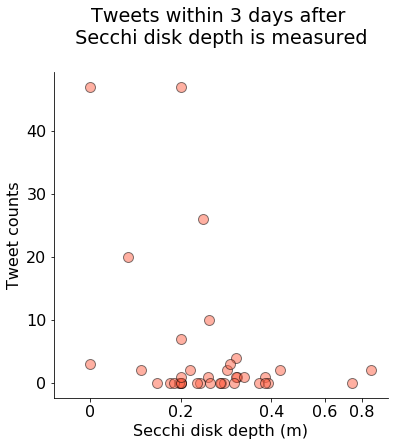

In [108]:
# change axis to log https://stackoverflow.com/questions/36266979/pyplot-generating-plot-with-set-xscalelog-and-xticker-labels-in-integer-for 

# Secchi disk depth

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['sd']['X75'], df['sd']['tweets_neg_3_after'], 
          color='tomato', alpha='0.5', s=100, edgecolor='black')
ax.set(xlabel="Secchi disk depth (m)", ylabel='Tweet counts',
           title="Tweets within 3 days after \n Secchi disk depth is measured \n")
ax.set_xscale('log')
ax.set_xticks([0.1, 0.2, 0.4, 0.6, 0.8])
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8])
plt.minorticks_off()
plt.savefig("../../output/bivariate plots/sd_plot2.png", bbox_inches = 'tight')
plt.show();

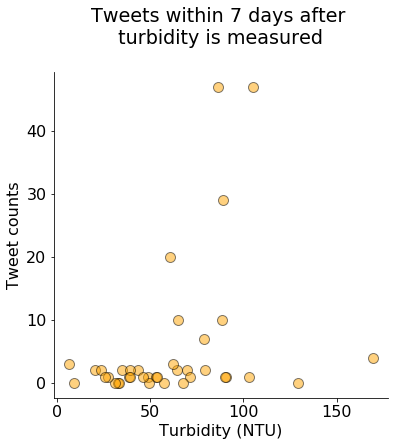

In [109]:
# Turbidity

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['t']['X75'], df['t']['tweets_neg_7_after'], 
          color='orange', alpha='0.5', s=100, edgecolor='black')
ax.set(xlabel="Turbidity (NTU)", ylabel='Tweet counts',
           title="Tweets within 7 days after \n turbidity is measured \n");
#ax.set_xscale('log')
#ax.set_xticks([50, 100, 150, 200])
#ax.set_xticklabels([50, 100, 150, 200])
#ax.tick_params(axis='x', which='minor')
plt.savefig("../../output/bivariate plots/t_plot2.png", bbox_inches = 'tight')
plt.show();

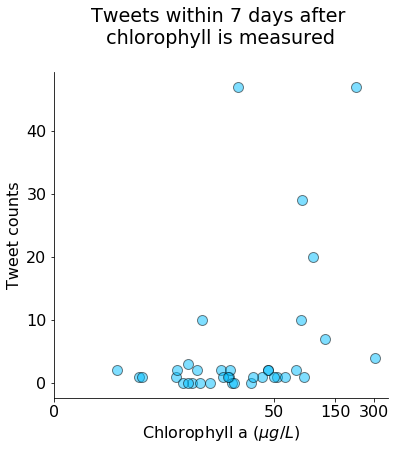

In [110]:
# Chlorophyll

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['c']['X75'], df['c']['tweets_neg_7_after'], 
          color='deepskyblue', alpha='0.5', s=100, edgecolor='black')
ax.set(xlabel="Chlorophyll a ($ \mu g / L$)", ylabel='Tweet counts',
           title="Tweets within 7 days after \n chlorophyll is measured \n")
ax.set_xscale('log')
ax.set_xticks([1, 50, 150, 300])
ax.set_xticklabels([0, 50, 150, 300])
plt.minorticks_off()
plt.savefig("../../output/bivariate plots/c_plot2.png", bbox_inches = 'tight')
plt.show();

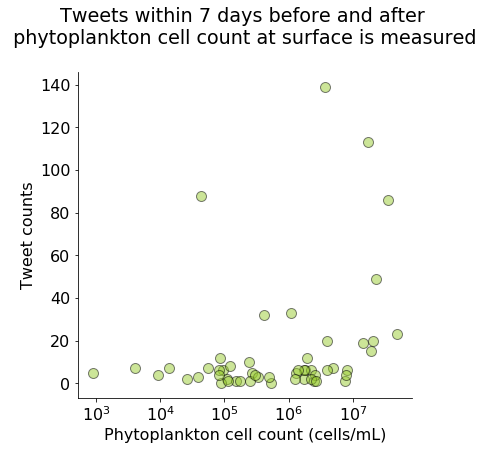

In [120]:
# Phytoplankton cell count (surface)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['tcc_s']['X75'], df['tcc_s']['tweets_neg_7_both'], 
          color='yellowgreen', alpha='0.5', s=100, edgecolor='black')
ax.set(xlabel="Phytoplankton cell count (cells/mL)", ylabel='Tweet counts',
           title="Tweets within 7 days before and after \n phytoplankton cell count at surface is measured \n")
ax.set_xscale('log')
#ax.set_xticks([1, 50, 150, 300])
#ax.set_xticklabels([0, 50, 150, 300])
plt.minorticks_off()
plt.savefig("../../output/bivariate plots/tcc_s_plot2.png", bbox_inches = 'tight')
plt.show();

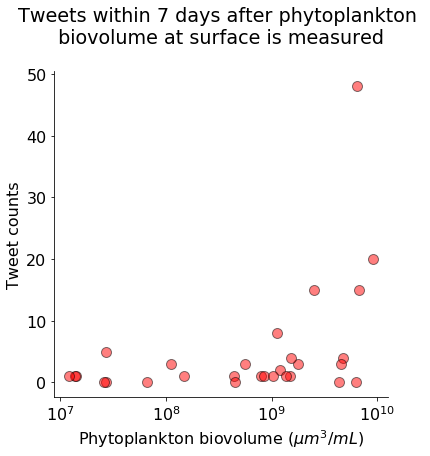

In [119]:
# Phytoplankton biovolume (surface)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['tb_s']['X75'], df['tb_s']['tweets_neg_7_after'], 
          color='red', alpha='0.5', s=100, edgecolor='black')
ax.set(xlabel="Phytoplankton biovolume ($ \mu m^3 / mL$)", ylabel='Tweet counts',
           title="Tweets within 7 days after phytoplankton \n biovolume at surface is measured \n")
ax.set_xscale('log')
#ax.set_xticks([1, 50, 150, 300])
#ax.set_xticklabels([0, 50, 150, 300])
plt.minorticks_off()
plt.savefig("../../output/bivariate plots/tb_s_plot2.png", bbox_inches = 'tight')
plt.show();

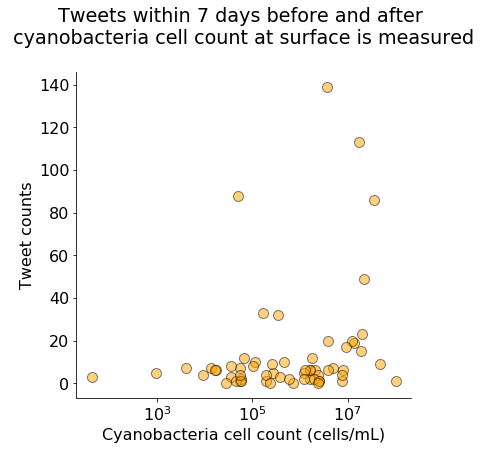

In [117]:
# Cyanobacteria cell count (surface)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['ccc_s']['X75'], df['ccc_s']['tweets_neg_7_both'], 
          color='orange', alpha='0.5', s=100, edgecolor='black')
ax.set(xlabel="Cyanobacteria cell count (cells/mL)", ylabel='Tweet counts',
           title="Tweets within 7 days before and after \n cyanobacteria cell count at surface is measured \n")
ax.set_xscale('log')
#ax.set_xticks([1, 50, 150, 300])
#ax.set_xticklabels([0, 50, 150, 300])
plt.minorticks_off()
plt.savefig("../../output/bivariate plots/ccc_s_plot2.png", bbox_inches = 'tight')
plt.show();

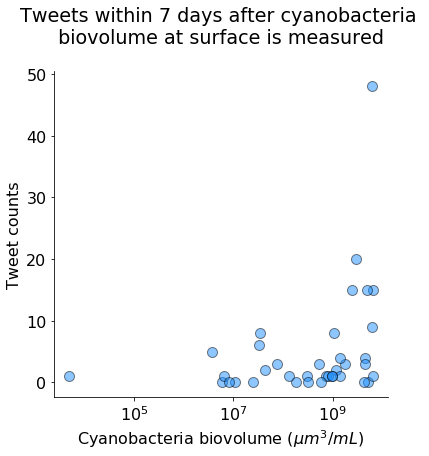

In [118]:
# Cyanobacteria biovolume (surface)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['cb_s']['X75'], df['cb_s']['tweets_neg_7_after'], 
          color='dodgerblue', alpha='0.5', s=100, edgecolor='black')
ax.set(xlabel="Cyanobacteria biovolume ($ \mu m^3 / mL$)", ylabel='Tweet counts',
           title="Tweets within 7 days after cyanobacteria \n biovolume at surface is measured \n")
ax.set_xscale('log')
#ax.set_xticks([1, 50, 150, 300])
#ax.set_xticklabels([0, 50, 150, 300])
plt.minorticks_off()
plt.savefig("../../output/bivariate plots/cb_s_plot2.png", bbox_inches = 'tight')
plt.show();

In [ ]:
# Create a function to make bivariate plots

def bivariate_plot(variable, title_name, axis_name, unit, col):
    
    def millions(x, pos):
        'The two args are the value and tick position'
        return '%1.0fM' % (x * 1e-6)
    
    # Make custome axis formatter object
    formatter = FuncFormatter(millions)
    
    fig = plt.figure(figsize=(12,12))

    ax1 = fig.add_subplot(2, 2, 1)
    ax1.scatter(df[variable]['X75'], df[variable]['tweets_neg_3_after'], color=col, 
               alpha=0.5, s=100, edgecolor='black')
    ax1.set(xlabel=f"{axis_name} ({unit})", ylabel='Tweet counts',
           title="3 days after")

    ax2 = fig.add_subplot(2, 2, 2)
    ax2.scatter(df[variable]['X75'], df[variable]['tweets_neg_3_both'], color=col, 
               alpha=0.5, s=100, edgecolor='black')
    ax2.set(xlabel=f"{axis_name} ({unit})", ylabel='Tweet counts', 
            title="3 days before and after")

    ax3 = fig.add_subplot(2, 2, 3)
    ax3.scatter(df[variable]['X75'], df[variable]['tweets_neg_7_after'], color=col, 
               alpha=0.5, s=100, edgecolor='black')
    ax3.set(xlabel=f"{axis_name} ({unit})", ylabel='Tweet counts',
           title="7 days after")

    ax4 = fig.add_subplot(2, 2, 4)
    ax4.scatter(df[variable]['X75'], df[variable]['tweets_neg_7_both'], color=col, 
               alpha=0.5, s=100, edgecolor='black')
    ax4.set(xlabel=f"{axis_name} ({unit})", ylabel='Tweet counts',
           title="7 days before and after")

    # Display axis in millions based on the highest value
    if np.max(df[variable]['X75']) > 10000000:
        ax1.xaxis.set_major_formatter(formatter)
        ax2.xaxis.set_major_formatter(formatter)
        ax3.xaxis.set_major_formatter(formatter)
        ax4.xaxis.set_major_formatter(formatter)
    
    # Rotate ticks if max is more than 1 billion units
    if np.max(df[variable]['X75']) > 1000000000:
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
        plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
        plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
    
    fig.suptitle(f"Rolling sum of tweets for {title_name} (n={len(df[variable])}) measurements")
    #fig.tight_layout()
    plt.subplots_adjust(hspace=0.5, wspace=0.2)
    plt.savefig(f"../../output/bivariate plots/{variable}_plot.png", bbox_inches = 'tight')
    plt.show();

## Secchi disk depth

In [ ]:
bivariate_plot('sd', 'Secchi disk depth', 'Secchi disk depth', 'm', 'tomato')

# Turbidity

In [ ]:
bivariate_plot('t', 'turbidity', 'Turbidity', 'NTU', 'orange')

# Chlorophyll

In [ ]:
bivariate_plot('c', 'chlorophyll', 'Chlorophyll', '$ \mu g / L$', 'deepskyblue')

# Total Suspended Solids

In [ ]:
bivariate_plot('tss', 'total suspended solids', 'Total Suspended Solids', 'mg/L', 'yellowgreen')

# Total Cell Count (composite)

In [ ]:
bivariate_plot('tcc_c', 'phytoplankton cell count composite', 'Cell count', 'cells/mL', 'firebrick')

# Total Cell Count (surface)

In [ ]:
bivariate_plot('tcc_s', 'phytoplankton cell count surface', 'Cell count', 'cells/mL', 'darkorange')

# Total Biovolume (composite)

In [ ]:
bivariate_plot('tb_c', 'phytoplankton biovolume composite', 'Biovolume', '$ \mu m^3 / mL$', 'dodgerblue')

# Total biovolume (surface)

In [ ]:
bivariate_plot('tb_s', 'phytoplankton biovolume surface', 'Biovolume', '$ \mu m^3 / mL$', 'lime')

# Cyano Cell Count (composite)

In [ ]:
bivariate_plot('ccc_c', 'cyanobacteria cell count composite', 'Cell count', 'cells/mL', 'tomato')

# Cyano Cell Count (surface)

In [ ]:
bivariate_plot('ccc_s', 'cyanobacteria cell count surface', 'Cell count', 'cells/mL', 'goldenrod')

# Cyano biovolume (composite)

In [ ]:
bivariate_plot('cb_c', 'cyanobacteria biovolume composite', 'Biovolume', '$ \mu m^3 / mL$', 'cornflowerblue')

# Cyano biovolume (surface)

In [ ]:
bivariate_plot('cb_s', 'cyanobacteria biovolume surface', 'Biovolume', '$ \mu m^3 / mL$', 'lawngreen')

In [ ]:
def histogram_3days(variable, plot_title):
    fig = plt.figure(figsize=(15,12))
    i = -10

    for num in range(1,10):

        ax1 = fig.add_subplot(3,3,num)
        ax1.hist(variable.iloc[:,i], color='pink', linewidth=1, edgecolor="white", bins=40)
        ax1.set(xlabel = variable.columns[i], ylabel=f'Number of observations')
        i-=1

    fig.suptitle(f"Distribution of total tweets in 3-day rolling window for {plot_title}, n={len(variable)}")
    #fig.tight_layout()
    plt.subplots_adjust(hspace=0.5, wspace=0.3)


## For some parameters zero-inflated poisson is not working...
## for same reason zero-inflated negative binomial wasn't working

# I. Secchi disk depth

## Tweet distributions

In [ ]:
display(histogram_3days(df["sd"], "Secchi disk depth"));
display(histogram_7days(df["sd"], "Secchi disk depth"));

## Models

In [ ]:
run_models()

# II. Turbidity

## Tweet distributions

In [ ]:
display(histogram_3days(df["t"], "Turbidity"));
display(histogram_7days(df["t"], "Turbidity"));

## Models 

In [ ]:
run_models()

# III. Chlorophyll a - Corrected for pheophytin

## Tweet distributions

In [ ]:
display(histogram_3days(df["c"], "Chlorophyll"));
display(histogram_7days(df["c"], "Chlorophyll"));

## Models 

In [ ]:
run_models()

# IV. Total Suspended Solids

## Tweet distributions

In [ ]:
display(histogram_3days(df["tss"], "Total suspended solids"));
display(histogram_7days(df["tss"], "Total suspended solids"));

## Models 

In [ ]:
run_models()

# V. Phytoplankton cell count

## Tweet distributions

In [ ]:
display(histogram_3days(df["tcc"], "Phytoplankton cell count"));
display(histogram_7days(df["tcc"], "Phytoplankton cell count"));

## Models 

In [ ]:
run_models()

# VI. Phytoplankton cell count (composite)

## Tweet distributions

In [ ]:
display(histogram_3days(df["tcc_c"], "Phytoplankton cell count (composite)"));
display(histogram_7days(df["tcc_c"], "Phytoplankton cell count (composite)"));

## Models 

In [ ]:
run_models()

# VII. Phytoplankton cell count (surface)

## Tweet distributions

In [ ]:
display(histogram_3days(df["tcc_s"], "Phytoplankton cell count (surface)"));
display(histogram_7days(df["tcc_s"], "Phytoplankton cell count (surface)"));

## Models 

In [ ]:
run_models()

# VIII. Phytoplankton biovolume 

## Tweet distributions

In [ ]:
display(histogram_3days(df["tb"], "Phytoplankton biovolume"));
display(histogram_7days(df["tb"], "Phytoplankton biovolume"));

## Models 

In [ ]:
run_models()

# IX. Phytoplankton biovolume (composite) 

## Tweet distributions

In [ ]:
display(histogram_3days(df["tb_c"], "Phytoplankton biovolume (composite)"));
display(histogram_7days(df["tb_c"], "Phytoplankton biovolume (composite)"));

## Models 

In [ ]:
run_models()

# X. Phytoplankton biovolume (surface)

## Tweet distributions

In [ ]:
display(histogram_3days(df["tb_s"], "Phytoplankton biovolume (surface)"));
display(histogram_7days(df["tb_s"], "Phytoplankton biovolume (surface)"));

## Models 

In [ ]:
run_models()

# XI. Cyanobacteria cell count

## Tweet distributions

In [ ]:
display(histogram_3days(df["ccc"], "Cyanobacteria cell count"));
display(histogram_7days(df["ccc"], "Cyanobacteria cell count"));

## Models 

In [ ]:
run_models()

# XII. Cyanobacteria cell count (composite)

## Tweet distributions

In [ ]:
display(histogram_3days(df["ccc_c"], "Cyanobacteria cell count (composite)"));
display(histogram_7days(df["ccc_c"], "Cyanobacteria cell count (composite)"));

## Models 

In [ ]:
run_models()

# XIII. Cyanobacteria cell count (surface)

## Tweet distributions

In [ ]:
display(histogram_3days(df["ccc_s"], "Cyanobacteria cell count (surface)"));
display(histogram_7days(df["ccc_s"], "Cyanobacteria cell count (surface)"));

## Models 

In [ ]:
run_models()

# XIV. Cyanobacteria biovolume 

## Tweet distributions

In [ ]:
display(histogram_3days(df["cb"], "Cyanobacteria biovolume"));
display(histogram_7days(df["cb"], "Cyanobacteria biovolume"));

## Models 

In [ ]:
run_models()

# XV. Cyanobacteria biovolume (composite) 

## Tweet distributions

In [ ]:
display(histogram_3days(df["cb_c"], "Cyanobacteria biovolume (composite)"));
display(histogram_7days(df["cb_c"], "Cyanobacteria biovolume (composite)"));

## Models 

In [ ]:
run_models()

# XVI. Cyanobacteria biovolume (surface)

## Tweet distributions

In [ ]:
display(histogram_3days(df["cb_s"], "Cyanobacteria biovolume (surface)"));
display(histogram_7days(df["cb_s"], "Cyanobacteria biovolume (surface)"));

## Models 

In [ ]:
run_models()

In [ ]:
names = ["c", "cb", "ccc", "sd", "tb", "tcc", "tss", "t", "tweets"]

In [ ]:
def poisson(wq, x, y):
    
    abc = df[wq]
    
    # Model formula
    formula = f"{y} ~ {x}"
    
    # Use Patsy package to carve out the x and y matrices for the ZIP model 
    Y, X = dmatrices(formula, abc, return_type='dataframe')
    
    # Fit the model
    model_p = sm.GLM(Y, X, family=sm.families.Poisson()).fit() #Fit the model using maximum likelihood
    
    return model_p.summary()

In [ ]:
# Create histogram

fig = plt.figure(figsize=(12,12))
i = -1

for num in range(1,10):

    ax1 = fig.add_subplot(3,3,num)
    ax1.hist(sd.iloc[:,i], color='lightskyblue', linewidth=1, edgecolor="white")
    ax1.set(xlabel = sd.columns[i], ylabel=f'Number of observations')
    i-=1

fig.suptitle(f"Tweets count distribution for {Secchi disk depth}, n={len(sd)}")
#fig.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

In [ ]:
# Calculate mean and variance (NOPE DONT DO IT)
# Fit zero-inflated poisson regression
# Fit negative binomial regression and Zero-inflated binomial regression (see why? in below link)
# Create residual vs fitter plots for both

In [ ]:
# example of doing poisson and negative 
# https://dius.com.au/2017/08/03/using-statsmodels-glms-to-model-beverage-consumption/

# we might not always need zero inflated model
# https://statisticalhorizons.com/zero-inflated-models

In [ ]:
df['sd']

In [ ]:
# Import explanatory and response variables data
tweets = pd.read_csv("../../data/processed/regression/tweets_daily_final.csv")
sd = pd.read_csv("../../data/processed/regression/secchi_depth_final.csv")
t = pd.read_csv("../../data/processed/regression/turbidity_final.csv")
tss = pd.read_csv("../../data/processed/regression/total_suspended_solids_final.csv")
c = pd.read_csv("../../data/processed/regression/chlorophyll_final.csv")
tcc = pd.read_csv("../../data/processed/regression/total_cell_count_final.csv")
tb = pd.read_csv("../../data/processed/regression/total_biovolume_final.csv")
ccc = pd.read_csv("../../data/processed/regression/cyano_cell_count_final.csv")
cb = pd.read_csv("../../data/processed/regression/cyano_biovolume_final.csv")


In [ ]:
# convert date column to datetime object
tweets['time'] = pd.to_datetime(tweets['time'])
sd['OBJECTID_1'] = pd.to_datetime(sd['OBJECTID_1'])
t['OBJECTID_1'] = pd.to_datetime(t['OBJECTID_1'])
tss['OBJECTID_1'] = pd.to_datetime(tss['OBJECTID_1'])
c['OBJECTID_1'] = pd.to_datetime(c['OBJECTID_1'])
tcc['OBJECTID_1'] = pd.to_datetime(tcc['OBJECTID_1'])
tb['OBJECTID_1'] = pd.to_datetime(tb['OBJECTID_1'])
ccc['OBJECTID_1'] = pd.to_datetime(ccc['OBJECTID_1'])
cb['OBJECTID_1'] = pd.to_datetime(cb['OBJECTID_1'])

In [ ]:
sd['OBJECTID_1'] = pd.to_datetime(sd['OBJECTID_1'])

In [ ]:
sd['OBJECTID_1'][0] 

In [ ]:
idx = tweets['time'].eq(sd['OBJECTID_1'][0]).idxmax()
res = tweets.iloc[idx-7: idx+1]

print(res)

In [ ]:
# create new columns to store tweet counts data

sd['tweets_neg_3_both'] = np.nan
sd['tweets_pos_3_both'] = np.nan
sd['tweets_wq_3_both']  = np.nan 

sd['tweets_neg_3_before'] = np.nan
sd['tweets_pos_3_before'] = np.nan
sd['tweets_wq_3_before']  = np.nan 

sd['tweets_neg_3_after'] = np.nan
sd['tweets_pos_3_after'] = np.nan
sd['tweets_wq_3_after']  = np.nan


sd['tweets_neg_7_both'] = np.nan
sd['tweets_pos_7_both'] = np.nan
sd['tweets_wq_7_both']  = np.nan

sd['tweets_neg_7_before'] = np.nan
sd['tweets_pos_7_before'] = np.nan
sd['tweets_wq_7_before']  = np.nan

sd['tweets_neg_7_after'] = np.nan
sd['tweets_pos_7_after'] = np.nan
sd['tweets_wq_7_after']  = np.nan


# Iterate over each row in wq variable
for index, row in sd.iterrows():
    
    # get dates for which we have water quality measurements
    date_wq = row['OBJECTID_1']
    
    # get index of the row with same date in the tweets data
    tweets_index = tweets['time'].eq(date_wq).idxmax()
    
    # get tweets info from 3 & 7 days before and after the date on which water quality was measured
    tweets_result_3_both = tweets.iloc[tweets_index-3: tweets_index+4]
    tweets_result_3_before = tweets.iloc[tweets_index-3: tweets_index+1]
    tweets_result_3_after = tweets.iloc[tweets_index: tweets_index+4]
    
    tweets_result_7_both = tweets.iloc[tweets_index-7: tweets_index+8]
    tweets_result_7_before = tweets.iloc[tweets_index-7: tweets_index+1]
    tweets_result_7_after = tweets.iloc[tweets_index: tweets_index+8]
    
    # assign the sum of negative tweets
    sd.loc[index, 'tweets_neg_3_both'] = tweets_result_3_both['neg'].sum() 
    sd.loc[index, 'tweets_pos_3_both'] = tweets_result_3_both['pos'].sum()
    sd.loc[index, 'tweets_wq_3_both'] = tweets_result_3_both['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_3_before'] = tweets_result_3_before['neg'].sum() 
    sd.loc[index, 'tweets_pos_3_before'] = tweets_result_3_before['pos'].sum()
    sd.loc[index, 'tweets_wq_3_before'] = tweets_result_3_before['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_3_after'] = tweets_result_3_after['neg'].sum() 
    sd.loc[index, 'tweets_pos_3_after'] = tweets_result_3_after['pos'].sum()
    sd.loc[index, 'tweets_wq_3_after'] = tweets_result_3_after['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_7_both'] = tweets_result_7_both['neg'].sum() 
    sd.loc[index, 'tweets_pos_7_both'] = tweets_result_7_both['pos'].sum()
    sd.loc[index, 'tweets_wq_7_both'] = tweets_result_7_both['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_7_before'] = tweets_result_7_before['neg'].sum() 
    sd.loc[index, 'tweets_pos_7_before'] = tweets_result_7_before['pos'].sum()
    sd.loc[index, 'tweets_wq_7_before'] = tweets_result_7_before['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_7_after'] = tweets_result_7_after['neg'].sum() 
    sd.loc[index, 'tweets_pos_7_after'] = tweets_result_7_after['pos'].sum()
    sd.loc[index, 'tweets_wq_7_after'] = tweets_result_7_after['water quality?'].sum()
    
    
#     print(date_wq)
#     print(tweets_result)

In [ ]:
sd.head(50)

In [ ]:
sd.columns = sd.columns.str.replace(".", "")

In [ ]:
# Regression - Zero inflated poisson regression (zip)
formula = "tweets_neg_3_both ~ X75"

# Use Patsy package to carve out the X and y matrices for ZIP model 
y, x = dmatrices(formula, sd, return_type='dataframe')

In [ ]:
# https://towardsdatascience.com/an-illustrated-guide-to-the-zero-inflated-poisson-model-b22833343057
model_zip = sm.ZeroInflatedPoisson(endog=y, exog=x, exog_infl=x, inflation='logit').fit(method='newton') #Fit the model using maximum likelihood
model_zip.summary()

In [ ]:
model.params

In [ ]:
# Regression - Zero Inflated Negative Binomial
# explantion abt zero inflation https://stats.stackexchange.com/questions/77745/zero-inflated-negative-binomial/257900
model_zinb = sm.ZeroInflatedNegativeBinomialP(endog=y, exog=x, exog_infl=x, inflation='logit').fit(method='ncg')
model_zinb.summary()

In [ ]:
sd.head()

In [ ]:
# Negative Binomial
model_p = sm.GLM(y, x, family=sm.families.Poisson()).fit()
model_p.summary()

In [ ]:
print(model_p.mu)
print(len(model_p.mu))

In [ ]:
sd_copy = sd.copy()
sd_copy['BB_LAMBDA'] = model_p.mu

In [ ]:
sd_copy['AUX_OLS_DEP'] = sd_copy.apply(lambda x: ((x['tweets_neg_3_both'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)

In [ ]:
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""

In [ ]:
aux_olsr_results = smf.ols(ols_expr, sd_copy).fit()

In [ ]:
print(aux_olsr_results.params)

In [ ]:
aux_olsr_results.tvalues #seeing the significant t-value for 95 percentile it is significant

In [ ]:
nb2_training_results = sm.GLM(y, x,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

In [ ]:
print(nb2_training_results.summary())

In [ ]:
# print out
# Export model as img
plt.rc('figure', figsize=(7,3))
plt.text(0.01, 0.05, str(nb2_training_results.summary()),
{'fontsize':22}, fontproperties =  'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig('../../output/regression/output.png')

In [ ]:
wq='sd'
x='X75'
y='tweets_neg_3_both'

In [ ]:
temp = df[wq]
formula = f"{y} ~ {x}"
Y, X = dmatrices(formula, temp, return_type='dataframe')
model_p = sm.GLM(Y, X, family=sm.families.Poisson()).fit()
temp2 = temp.copy()
temp2['rate_lambda'] = model_p.mu
temp2['aux_ols_dependent'] = temp2.apply(lambda t: ((t[y] - t['rate_lambda'])**2 - t['rate_lambda']) / t['rate_lambda'], axis=1)
ols_formula = """aux_ols_dependent ~ rate_lambda - 1"""

model_aux_olsr = smf.ols(ols_formula, temp2).fit()

In [ ]:
def poisson(wq, x, y):
    
    temp = df[wq]
    
    # Model formula
    formula = f"{y} ~ {x}"
    
    # Use Patsy package to carve out the x and y matrices for the ZIP model 
    Y, X = dmatrices(formula, temp, return_type='dataframe')
    
    # Fit the model
    model_p = sm.GLM(Y, X, family=sm.families.Poisson()).fit() #Fit the model using maximum likelihood
    
    return model_p, Y, X

In [ ]:
def negative_binomial(wq, x, y):
    
    poisson(wq, x, y)
    
#     temp = df[wq]
    
#     # Model formula
#     formula = f"{y} ~ {x}"
    
#     # Use Patsy package to carve out the x and y matrices for the ZIP model 
#     Y, X = dmatrices(formula, temp, return_type='dataframe')
    
#     # Fit the model
#     model_p = sm.GLM(Y, X, family=sm.families.Poisson()).fit() #Fit the model using maximum likelihood
    
    # Obtain rate vector from Poisson model
    temp2 = temp.copy()
    temp2['rate_lambda'] = model_p.mu
    
    # Auxiliary OLS regression to find α for the NB2 model
    # Calculate the dependent variable
    temp2['aux_ols_dependent'] = temp2.apply(lambda t: ((t[y] - t['rate_lambda'])**2 - t['rate_lambda']) / t['rate_lambda'], axis=1)
    
    # Using the α as dependent variable in an OLS regression model
    ols_formula = """aux_ols_dependent ~ rate_lambda - 1"""
    
    # Fitting the OLS regression model
    model_aux_olsr = smf.ols(ols_formula, temp2).fit()
    
    # The model coefficient is the alpha parameter for our negative binomial
    alpha = model_aux_olsr.params[0]
    
    # Get the associate t-value to determine significance
    t_value = model_aux_olsr.tvalues[0]
    
    # Caluclate degrees of freedom (number of observations - regression variables - dispersion variable)
    deg_freedom = len(temp2) - 1 - 1
    
    # Determine t critical value at 95% significance value
    t_critical = scipy.stats.t.ppf(q=1-.05,df=deg_freedom)
    
    # If the alpha is significant, negative binomial can be a better fit than poisson
    if (t_value > t_critical):
        print ("Alpha parameter of negative binomial regression is significant")
    else:
        print ("Alpha parameter of negative binomial regression is not significant")
        
    # Fit negative binomial regression model
    model_nb = sm.GLM(Y, X,family=sm.families.NegativeBinomial(alpha=alpha)).fit()
    
    return model_nb.summary()

In [ ]:
negative_binomial('sd', 'X75', 'tweets_neg_3_both')

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



In [ ]:
def f(x):
    return x
interact(f, x=[('oneeeeeeeeeeeeeeeeeeeeffffffffffddddddddddddddddddddddddd', '10'), ('two', 20)]);

In [ ]:
fig = plt.figure(figsize=(12,11))

ax1 = fig.add_subplot(2, 2, 1)
ax1.scatter(df['sd']['X75'], df['sd']['tweets_neg_3_after'], color='orange', 
           alpha=0.5, s=100, edgecolor='black')
ax1.set(xlabel="Secchi disk depth (m)", ylabel='Tweet counts',
       title="3 days after")

ax1 = fig.add_subplot(2, 2, 2)
ax1.scatter(df['sd']['X75'], df['sd']['tweets_neg_3_both'], color='red', 
           alpha=0.5, s=100, edgecolor='black')
ax1.set(xlabel="Secchi disk depth (m)", ylabel='Tweet counts', 
        title="3 days before and after")

ax1 = fig.add_subplot(2, 2, 3)
ax1.scatter(df['sd']['X75'], df['sd']['tweets_neg_7_after'], color='cyan', 
           alpha=0.5, s=100, edgecolor='black')
ax1.set(xlabel="Secchi disk depth (m)", ylabel='Tweet counts',
       title="7 days after")

ax1 = fig.add_subplot(2, 2, 4)
ax1.scatter(df['sd']['X75'], df['sd']['tweets_neg_7_both'], color='pink', 
           alpha=0.5, s=100, edgecolor='black')
ax1.set(xlabel="Secchi disk depth (m)", ylabel='Tweet counts',
       title="7 days before and after")


fig.suptitle(f"Rolling sum of tweets for Secchi disk depth (n={len(df['sd'])}) measurments")
#fig.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.savefig("../../output/bivariate plots/sd_plot.png", bbox_inches = 'tight')
plt.show();